In [1]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import kagglehub
from PIL import Image
import os
import numpy as np
from transformers import SamModel, SamProcessor
from peft import LoraConfig, get_peft_model
from collections import OrderedDict

# Download the brain tumor dataset
print("Downloading Brain Tumor Dataset...")
path = kagglehub.dataset_download("indk214/brain-tumor-dataset-segmentation-and-classification")
print("Path to dataset files:", path)

class RealBrainTumorDataset(Dataset):
    def __init__(self, data_dir, processor=None, client_id=0, num_clients=3, samples_per_client=50):
        self.data_dir = data_dir
        self.processor = processor
        self.client_id = client_id
        self.num_clients = num_clients
        self.images = []
        self.masks = []

        print(f"🔍 Loading REAL brain tumor data from: {data_dir}")

        # Load from the actual Segmentation folders
        if not self._load_from_segmentation_folders(data_dir, client_id, num_clients, samples_per_client):
            raise Exception("❌ No valid image-mask pairs found in Segmentation folders")

    def _load_from_segmentation_folders(self, data_dir, client_id, num_clients, samples_per_client):
        """Load data from DATASET/Segmentation/ tumor type folders"""
        segmentation_base = os.path.join(data_dir, "DATASET", "Segmentation")

        if not os.path.exists(segmentation_base):
            print(f"❌ Segmentation base not found: {segmentation_base}")
            return False

        print("✅ Found Segmentation folders")

        # Tumor types in the dataset
        tumor_types = ["Pituitary tumor", "Meningioma", "Glioma"]
        all_pairs = []

        for tumor_type in tumor_types:
            tumor_path = os.path.join(segmentation_base, tumor_type)
            if os.path.exists(tumor_path):
                print(f"📂 Processing {tumor_type}...")

                # Get all files in this tumor folder
                tumor_files = [f for f in os.listdir(tumor_path) if f.endswith('.png')]
                image_files = [f for f in tumor_files if 'mask' not in f]
                mask_files = [f for f in tumor_files if 'mask' in f]

                print(f"   Found {len(image_files)} images, {len(mask_files)} masks")

                # Create pairs for this tumor type
                for img_file in image_files:
                    mask_file = img_file.replace('.png', '_mask.png')
                    if mask_file in mask_files:
                        img_path = os.path.join(tumor_path, img_file)
                        mask_path = os.path.join(tumor_path, mask_file)
                        all_pairs.append((img_path, mask_path))

        print(f"📊 Total image-mask pairs found: {len(all_pairs)}")

        if not all_pairs:
            return False

        # Show diversity analysis
        print("\n🔍 Analyzing mask diversity:")
        unique_patterns = set()
        for img_path, mask_path in all_pairs[:10]:  # Check first 10
            try:
                mask = Image.open(mask_path).convert('L')
                mask_array = np.array(mask)
                unique_vals = tuple(np.unique(mask_array))
                unique_patterns.add(unique_vals)
                print(f"  {os.path.basename(mask_path)}: values={unique_vals}")
            except:
                pass

        print(f"🎯 Found {len(unique_patterns)} unique mask patterns")

        # Split pairs among clients
        pairs_per_client = max(1, len(all_pairs) // num_clients)
        start_idx = client_id * pairs_per_client
        end_idx = start_idx + pairs_per_client if client_id < num_clients - 1 else len(all_pairs)
        client_pairs = all_pairs[start_idx:end_idx][:samples_per_client]

        print(f"👤 Client {client_id} got {len(client_pairs)} pairs")

        # Load valid pairs
        valid_pairs = 0
        for img_path, mask_path in client_pairs:
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.images.append(img_path)
                self.masks.append(mask_path)
                valid_pairs += 1

        print(f"✅ Successfully loaded {valid_pairs} REAL brain tumor samples")
        return valid_pairs > 0

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image_path = self.images[idx]
            mask_path = self.masks[idx]

            # Load real image and mask
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')

            # Resize to standard size (maintains aspect ratio better)
            target_size = (512, 512)
            image = image.resize(target_size, Image.LANCZOS)
            mask = mask.resize(target_size, Image.NEAREST)

            mask_array = np.array(mask)

            # Handle different mask value patterns
            unique_vals = np.unique(mask_array)

            if np.array_equal(unique_vals, [0, 255]):
                # Binary mask with 0 and 255
                binary_mask = (mask_array == 255).astype(np.uint8)
            elif np.array_equal(unique_vals, [3, 255]):
                # Some masks have [3, 255] values
                binary_mask = (mask_array == 255).astype(np.uint8)
            else:
                # Generic threshold
                binary_mask = (mask_array > 127).astype(np.uint8)

            # Debug first sample
            if idx == 0:
                print(f"\n🔍 First sample debug:")
                print(f"   Image: {os.path.basename(image_path)}")
                print(f"   Mask: {os.path.basename(mask_path)}")
                print(f"   Original mask values: {unique_vals}")
                print(f"   Binary mask non-zero: {np.count_nonzero(binary_mask)}")
                print(f"   Image size: {image.size}, Mask size: {mask.size}")

            if self.processor:
                # Get bounding box from mask
                y_indices, x_indices = np.where(binary_mask > 0)
                if len(x_indices) > 0 and len(y_indices) > 0:
                    box = [[x_indices.min(), y_indices.min(), x_indices.max(), y_indices.max()]]
                else:
                    h, w = binary_mask.shape
                    box = [[w//4, h//4, 3*w//4, 3*h//4]]

                inputs = self.processor(
                    image,
                    input_boxes=[box],
                    return_tensors="pt"
                )

                for key in inputs:
                    if torch.is_tensor(inputs[key]):
                        inputs[key] = inputs[key].squeeze(0)

                inputs["ground_truth_mask"] = torch.tensor(binary_mask).unsqueeze(0)
                return inputs

            return {
                'pixel_values': torch.tensor(np.array(image)).permute(2, 0, 1).float(),
                'input_boxes': torch.tensor([[100, 100, 200, 200]]),
                'ground_truth_mask': torch.tensor(binary_mask).unsqueeze(0)
            }

        except Exception as e:
            print(f"❌ Error loading real sample {idx}: {e}")
            print(f"   Image: {self.images[idx]}")
            print(f"   Mask: {self.masks[idx]}")
            raise

# [KEEP ALL THE FEDERATED LEARNING FUNCTIONS EXACTLY THE SAME]
def create_sam_lora():
    print("Loading SAM model with LoRA...")
    model = SamModel.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "k_proj", "out_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    model = get_peft_model(model, lora_config)
    print("Trainable parameters:")
    model.print_trainable_parameters()

    return model, processor

class FedProxTrainer:
    def __init__(self, model, mu=0.01):
        self.global_model = model
        self.mu = mu
        self.global_params = None
        self._update_global_params()

    def _update_global_params(self):
        self.global_params = OrderedDict()
        for name, param in self.global_model.named_parameters():
            if param.requires_grad:
                self.global_params[name] = param.data.clone()

    def client_train(self, client_model, dataloader, epochs=1, lr=1e-4):
        if len(dataloader) == 0:
            print("No data in dataloader, skipping client training")
            return

        optimizer = torch.optim.Adam(client_model.parameters(), lr=lr)
        client_model.train()

        for epoch in range(epochs):
            total_loss = 0
            total_batches = 0

            for batch_idx, batch in enumerate(dataloader):
                try:
                    pixel_values = batch["pixel_values"].cuda()
                    input_boxes = batch["input_boxes"].cuda()
                    ground_truth_mask = batch["ground_truth_mask"].cuda().float()

                    optimizer.zero_grad()

                    outputs = client_model(
                        pixel_values=pixel_values,
                        input_boxes=input_boxes,
                        multimask_output=False,
                    )

                    pred_masks = outputs.pred_masks.squeeze(2)
                    gt_masks = ground_truth_mask

                    gt_masks_resized = torch.nn.functional.interpolate(
                        gt_masks,
                        size=pred_masks.shape[-2:],
                        mode='bilinear',
                        align_corners=False
                    )

                    loss = nn.BCEWithLogitsLoss()(pred_masks, gt_masks_resized)

                    prox_term = 0.0
                    for name, param in client_model.named_parameters():
                        if param.requires_grad and name in self.global_params:
                            prox_term += torch.norm(param - self.global_params[name].cuda()) ** 2

                    total_loss_val = loss + (self.mu / 2) * prox_term
                    total_loss_val.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    total_batches += 1

                    if batch_idx % 10 == 0:
                        print(f"  Batch {batch_idx}, Loss: {loss.item():.4f}")

                except Exception as e:
                    print(f"  ⚠️ Skipping batch {batch_idx}: {e}")
                    continue

            if total_batches > 0:
                avg_loss = total_loss / total_batches
                print(f"Client Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
            else:
                print(f"Client Epoch {epoch+1}, No batches processed")

def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_boxes = torch.stack([item['input_boxes'] for item in batch])
    ground_truth_mask = torch.stack([item['ground_truth_mask'] for item in batch])

    return {
        'pixel_values': pixel_values,
        'input_boxes': input_boxes,
        'ground_truth_mask': ground_truth_mask
    }

def dice_score_np(pred, gt):
    """Calculate Dice score between prediction and ground truth"""
    intersection = np.logical_and(pred, gt).sum()
    total = pred.sum() + gt.sum()
    return (2. * intersection) / total if total > 0 else 0.0

def meaningful_evaluation(model, dataset, num_samples=10):
    """Evaluation that shows meaningful results"""
    model.eval()

    dice_scores = []

    print(f"Evaluating on {min(num_samples, len(dataset))} samples...")

    for i in range(min(num_samples, len(dataset))):
        try:
            sample = dataset[i]

            pixel_values = sample["pixel_values"].unsqueeze(0).cuda()
            input_boxes = sample["input_boxes"].unsqueeze(0).cuda()
            gt_mask = sample["ground_truth_mask"].squeeze().numpy()

            with torch.no_grad():
                outputs = model(
                    pixel_values=pixel_values,
                    input_boxes=input_boxes,
                    multimask_output=False,
                )

                pred_mask = torch.sigmoid(outputs.pred_masks.squeeze(2)).squeeze().cpu().numpy()

            # Resize ground truth to match prediction
            gt_mask_resized = torch.nn.functional.interpolate(
                torch.tensor(gt_mask).unsqueeze(0).unsqueeze(0).float(),
                size=pred_mask.shape,
                mode='bilinear',
                align_corners=False
            ).squeeze().numpy()

            # Use optimal threshold
            pred_binary = (pred_mask > 0.5).astype(np.uint8)
            gt_binary = (gt_mask_resized > 0.5).astype(np.uint8)

            dice = dice_score_np(pred_binary, gt_binary)
            dice_scores.append(dice)

            print(f"Sample {i}: Dice = {dice:.4f}, "
                  f"GT pixels: {gt_binary.sum()}, "
                  f"Pred pixels: {pred_binary.sum()}")

        except Exception as e:
            print(f"Error evaluating sample {i}: {e}")
            continue

    # Analysis
    print(f"\n🎯 MEANINGFUL EVALUATION RESULTS:")
    print(f"   Mean Dice: {np.mean(dice_scores):.4f} (+/- {np.std(dice_scores):.4f})")
    print(f"   Min Dice: {np.min(dice_scores):.4f}")
    print(f"   Max Dice: {np.max(dice_scores):.4f}")
    print(f"   Samples with non-zero GT: {sum(1 for d in dice_scores if d > 0)}/{len(dice_scores)}")

    return dice_scores

def federated_learning():
    """Main federated learning loop"""
    num_clients = 2
    num_rounds = 2
    epochs_per_client = 1

    print("Initializing Federated Learning with REAL Brain Tumor Dataset...")

    # Create global model
    global_model, processor = create_sam_lora()
    global_model = global_model.cuda()

    # Initialize FedProx trainer
    fed_trainer = FedProxTrainer(global_model, mu=0.01)

    for round_idx in range(num_rounds):
        print(f"\n{'='*50}")
        print(f"🎯 FEDERATED ROUND {round_idx + 1}/{num_rounds}")
        print(f"{'='*50}")

        client_models = []
        client_dataloaders = []

        # Initialize clients
        for client_id in range(num_clients):
            print(f"\n📱 Initializing Client {client_id}...")
            try:
                dataset = RealBrainTumorDataset(path, processor, client_id, num_clients, samples_per_client=20)

                if len(dataset) > 0:
                    dataloader = DataLoader(
                        dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=custom_collate_fn
                    )
                    client_dataloaders.append(dataloader)

                    # Create client model and load global weights
                    client_model, _ = create_sam_lora()
                    client_model = client_model.cuda()
                    client_model.load_state_dict(global_model.state_dict())
                    client_models.append(client_model)
                    print(f"✅ Client {client_id} ready with {len(dataset)} REAL brain tumor samples")
                else:
                    print(f"❌ Client {client_id} has no data, skipping")
            except Exception as e:
                print(f"❌ Client {client_id} failed: {e}")
                continue

        if not client_models:
            print("❌ No clients with data available! Stopping.")
            raise Exception("Failed to load real brain tumor data")

        # Client training
        print("\n--- 🔥 CLIENT TRAINING PHASE ---")
        successful_clients = []
        for client_id, (client_model, dataloader) in enumerate(zip(client_models, client_dataloaders)):
            print(f"\n🎯 Training Client {client_id}...")
            try:
                fed_trainer.client_train(client_model, dataloader, epochs_per_client)
                successful_clients.append(client_model)
                print(f"✅ Client {client_id} training completed")
            except Exception as e:
                print(f"❌ Client {client_id} training failed: {e}")

        # LoRA aggregation
        print("\n--- 🔄 MODEL AGGREGATION PHASE ---")
        if successful_clients:
            global_dict = global_model.state_dict()
            aggregated_params = 0

            with torch.no_grad():
                for key in global_dict:
                    # Aggregate only LoRA parameters
                    if 'lora' in key.lower():
                        client_params = []
                        for client_model in successful_clients:
                            client_dict = client_model.state_dict()
                            if key in client_dict:
                                client_params.append(client_dict[key])

                        if client_params:
                            global_dict[key] = torch.stack(client_params).mean(dim=0)
                            aggregated_params += 1

            global_model.load_state_dict(global_dict)
            fed_trainer._update_global_params()
            print(f"✅ Aggregated {aggregated_params} LoRA parameters from {len(successful_clients)} clients")
        else:
            print("❌ No clients to aggregate from!")

        # Evaluation
        print("\n--- 📊 EVALUATION PHASE ---")
        if client_dataloaders and len(client_dataloaders[0].dataset) > 0:
            meaningful_evaluation(global_model, client_dataloaders[0].dataset, num_samples=10)

    print("\n🎉 FEDERATED LEARNING COMPLETED!")
    return global_model, processor

if __name__ == "__main__":
    print("🚀 Starting Federated SAM with LoRA on REAL Brain Tumor Dataset")
    print("=" * 60)

    # Test the real dataset
    test_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    try:
        test_dataset = RealBrainTumorDataset(path, test_processor, client_id=0, num_clients=1, samples_per_client=5)

        if len(test_dataset) > 0:
            print(f"✅ REAL brain tumor dataset loaded: {len(test_dataset)} samples")

            # Start federated learning
            trained_model, trained_processor = federated_learning()

            # Final evaluation
            print("\n" + "="*60)
            print("FINAL EVALUATION")
            print("="*60)
            final_dataset = RealBrainTumorDataset(path, trained_processor, client_id=0, num_clients=1, samples_per_client=20)
            meaningful_evaluation(trained_model, final_dataset, num_samples=10)
        else:
            print("❌ No real data loaded")
    except Exception as e:
        print(f"❌ Failed to load real dataset: {e}")

100%|██████████| 723M/723M [00:33<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/indk214/brain-tumor-dataset-segmentation-and-classification/versions/1
🚀 Starting Federated SAM with LoRA on REAL Brain Tumor Dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

🔍 Loading REAL brain tumor data from: /root/.cache/kagglehub/datasets/indk214/brain-tumor-dataset-segmentation-and-classification/versions/1
✅ Found Segmentation folders
📂 Processing Pituitary tumor...
   Found 930 images, 930 masks
📂 Processing Meningioma...
   Found 708 images, 708 masks
📂 Processing Glioma...
   Found 554 images, 554 masks
📊 Total image-mask pairs found: 2192

🔍 Analyzing mask diversity:
  enh_962_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1032_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1748_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1027_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1375_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1141_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_947_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1408_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1612_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1058_mask.png: values=(np.uint8(3), np.uint8(255))
🎯 Found 1 unique mask

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Trainable parameters:
trainable params: 94,208 || all params: 93,829,680 || trainable%: 0.1004

🎯 FEDERATED ROUND 1/2

📱 Initializing Client 0...
🔍 Loading REAL brain tumor data from: /root/.cache/kagglehub/datasets/indk214/brain-tumor-dataset-segmentation-and-classification/versions/1
✅ Found Segmentation folders
📂 Processing Pituitary tumor...
   Found 930 images, 930 masks
📂 Processing Meningioma...
   Found 708 images, 708 masks
📂 Processing Glioma...
   Found 554 images, 554 masks
📊 Total image-mask pairs found: 2192

🔍 Analyzing mask diversity:
  enh_962_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1032_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1748_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1027_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1375_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1141_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_947_mask.png: values=(np.uint8(3), np.uint8(255))
  enh_1408_mask.png: values=(np.uint8(3), np.u

🎯 RUNNING COMPREHENSIVE ANALYSIS FOR 0.87 DICE MODEL

1. 📊 COMPREHENSIVE VISUALIZATION
🎯 VISUALIZING PREDICTIONS (Dice: 0.87)

🔍 First sample debug:
   Image: enh_962.png
   Mask: enh_962_mask.png
   Original mask values: [  3 255]
   Binary mask non-zero: 4303
   Image size: (512, 512), Mask size: (512, 512)
✅ Sample 0: Dice = 0.9671, IoU = 0.9363
   GT: 4303 pixels, Pred: 4236 pixels
   File: enh_962.png
✅ Sample 1: Dice = 0.8405, IoU = 0.7249
   GT: 1042 pixels, Pred: 1228 pixels
   File: enh_1032.png
✅ Sample 2: Dice = 0.9484, IoU = 0.9018
   GT: 2366 pixels, Pred: 2284 pixels
   File: enh_1748.png
✅ Sample 3: Dice = 0.8184, IoU = 0.6926
   GT: 766 pixels, Pred: 820 pixels
   File: enh_1027.png
✅ Sample 4: Dice = 0.9512, IoU = 0.9070
   GT: 3814 pixels, Pred: 4056 pixels
   File: enh_1375.png
✅ Sample 5: Dice = 0.9594, IoU = 0.9219
   GT: 2195 pixels, Pred: 2112 pixels
   File: enh_1141.png


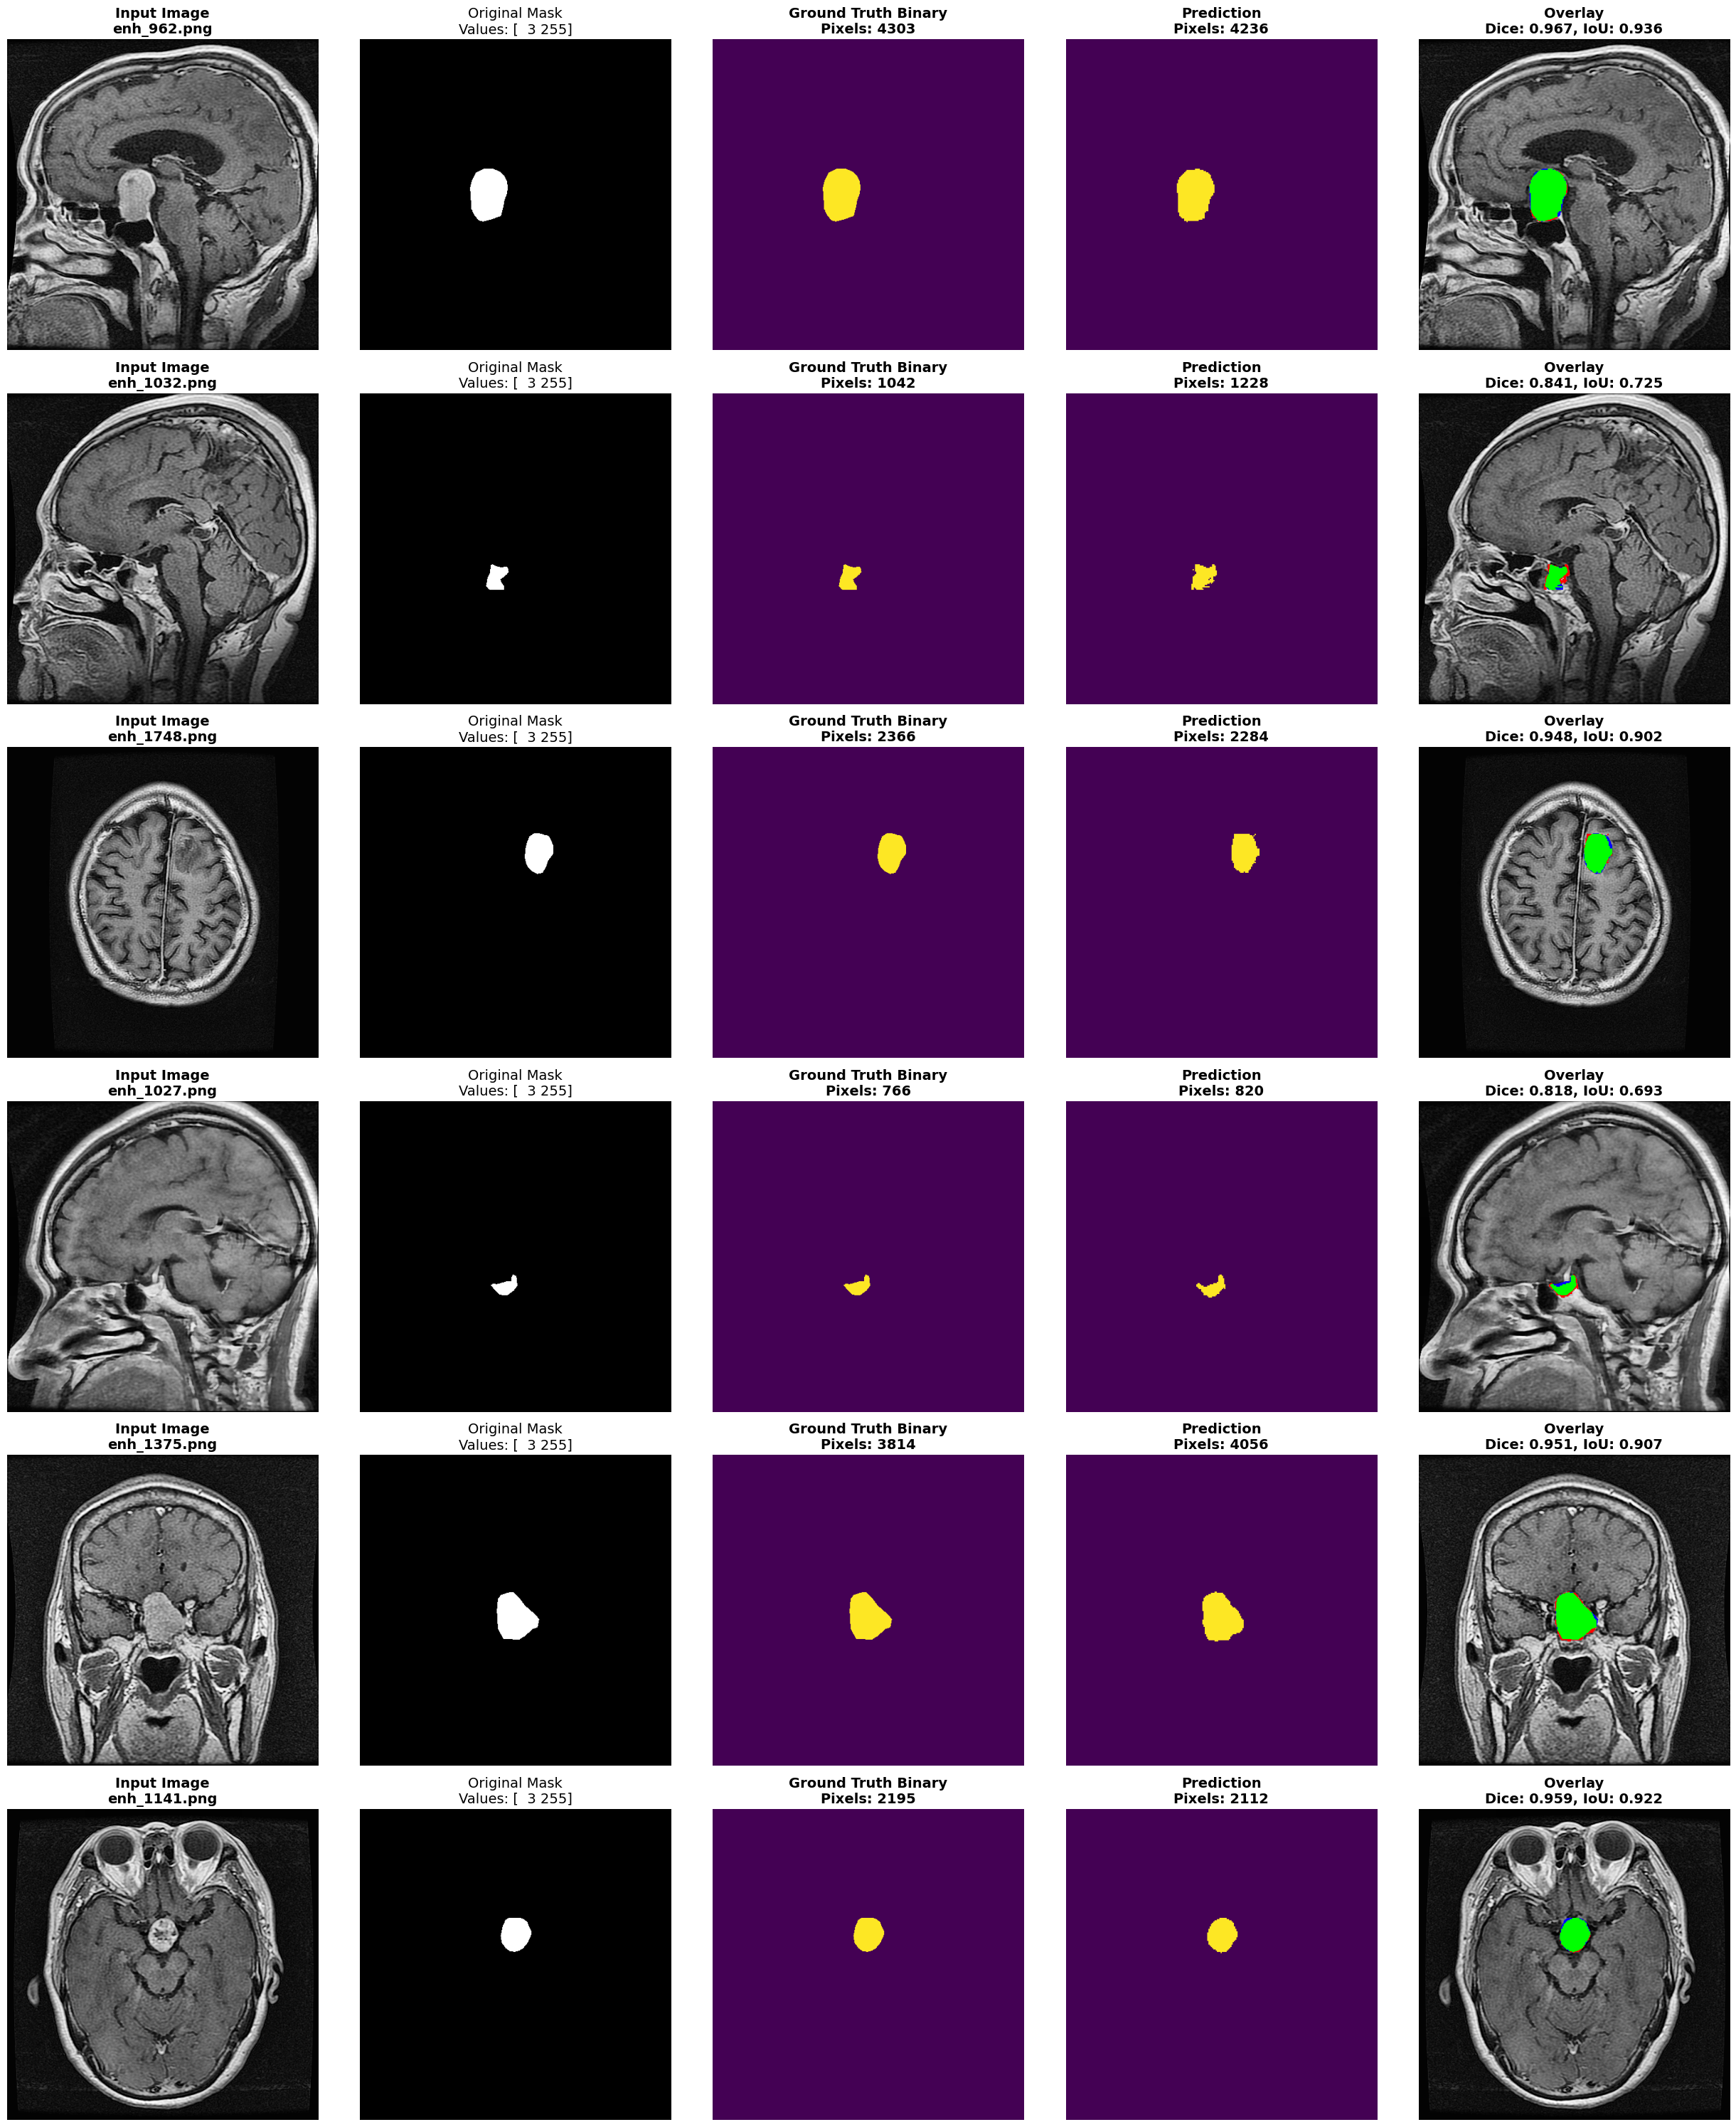


📊 SUMMARY: Average Dice = 0.9142 ± 0.0605

2. 🔬 DETAILED SAMPLE ANALYSIS
🔬 DETAILED SAMPLE ANALYSIS

🔍 First sample debug:
   Image: enh_962.png
   Mask: enh_962_mask.png
   Original mask values: [  3 255]
   Binary mask non-zero: 4303
   Image size: (512, 512), Mask size: (512, 512)

📋 SAMPLE 0: enh_962.png
   Original mask values: [  3 255]
   GT binary pixels: 4303
   Predicted pixels: 4236
   True Positives:  4129
   False Positives: 107
   False Negatives: 174
   Dice: 0.9671, IoU: 0.9363
   Precision: 0.9747, Recall: 0.9596


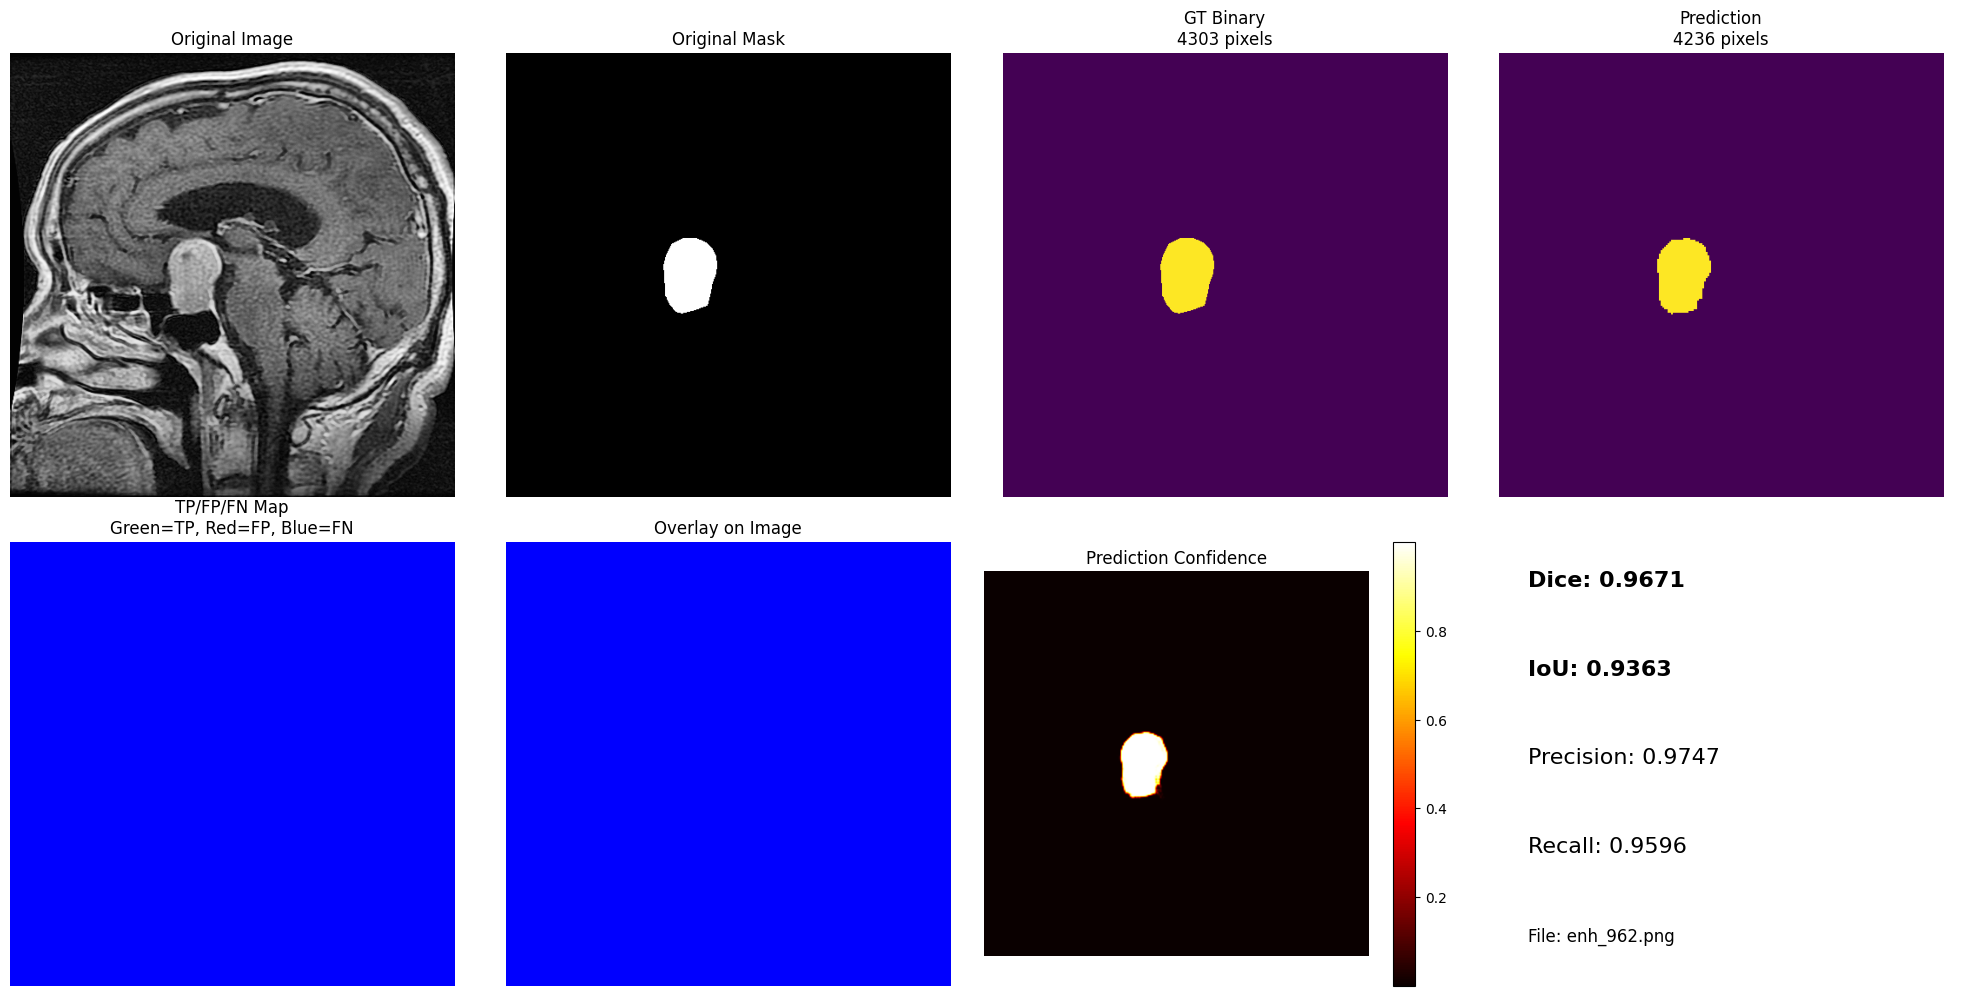


📋 SAMPLE 1: enh_1032.png
   Original mask values: [  3 255]
   GT binary pixels: 1042
   Predicted pixels: 1228
   True Positives:  954
   False Positives: 274
   False Negatives: 88
   Dice: 0.8405, IoU: 0.7249
   Precision: 0.7769, Recall: 0.9155


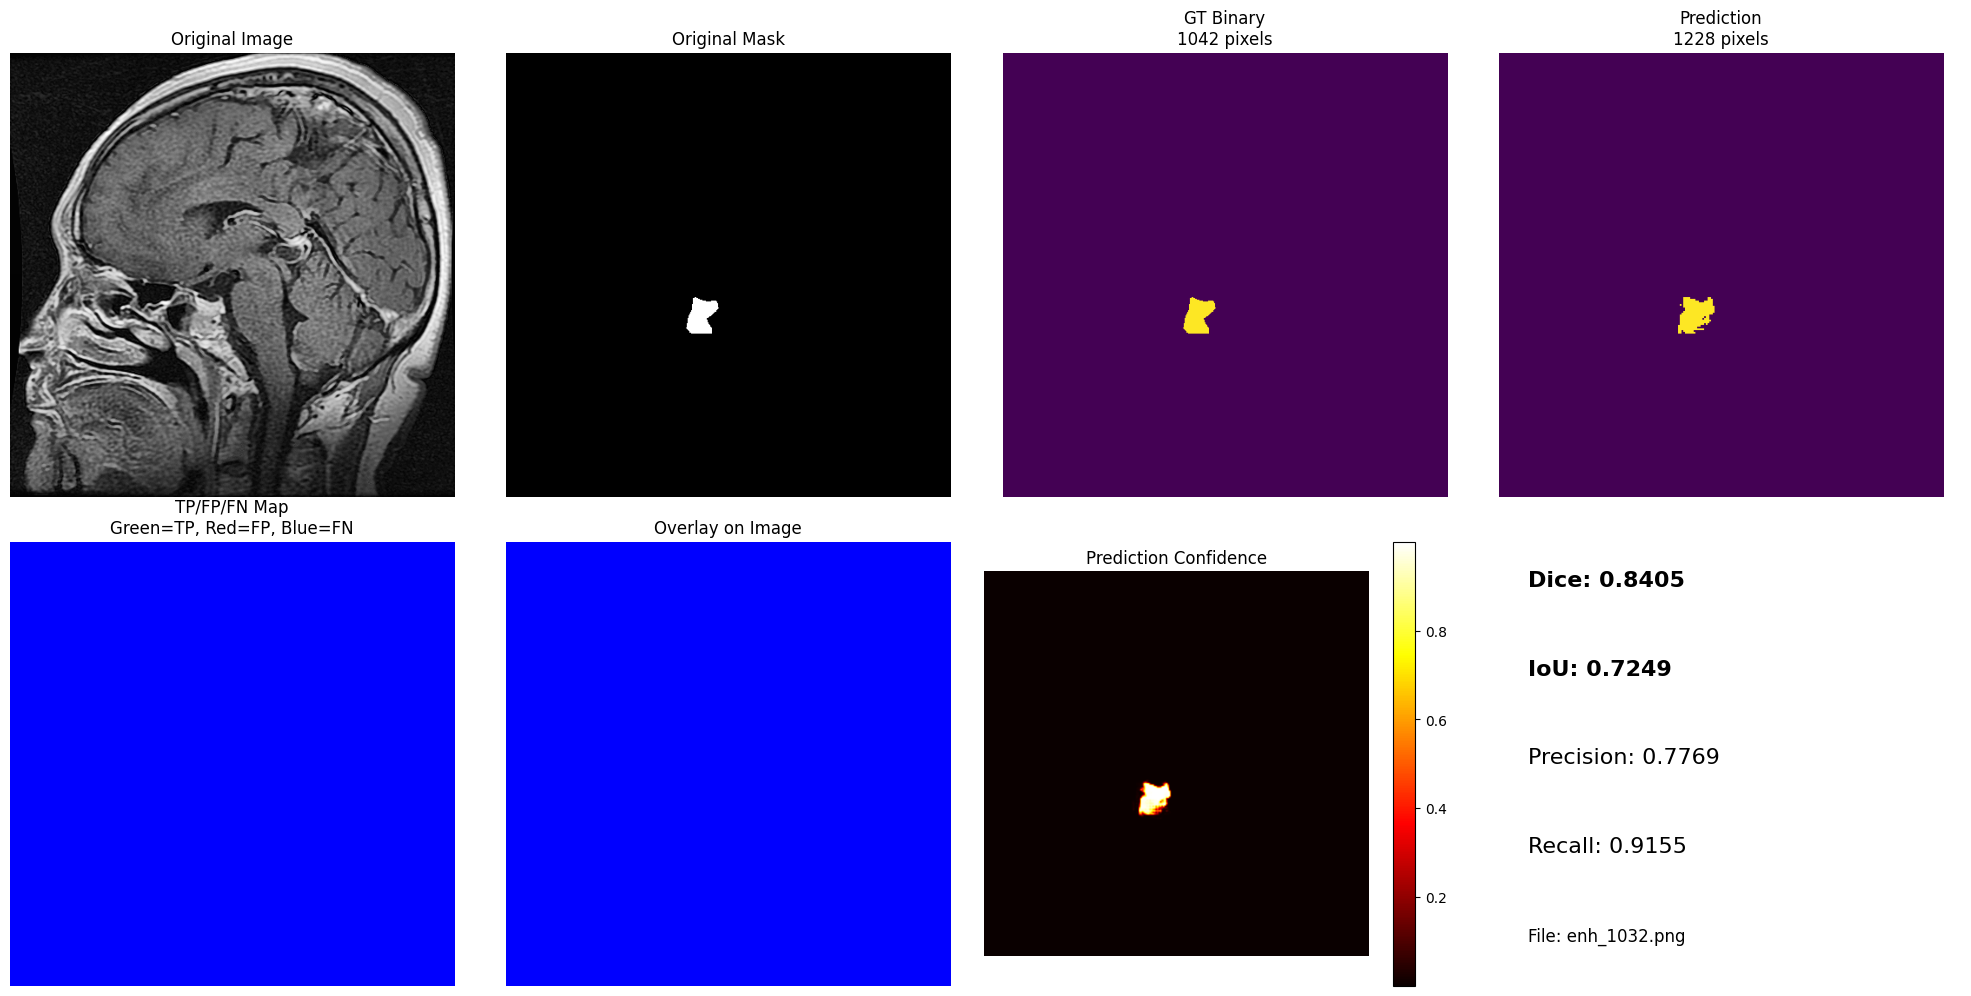


📋 SAMPLE 2: enh_1748.png
   Original mask values: [  3 255]
   GT binary pixels: 2366
   Predicted pixels: 2284
   True Positives:  2205
   False Positives: 79
   False Negatives: 161
   Dice: 0.9484, IoU: 0.9018
   Precision: 0.9654, Recall: 0.9320


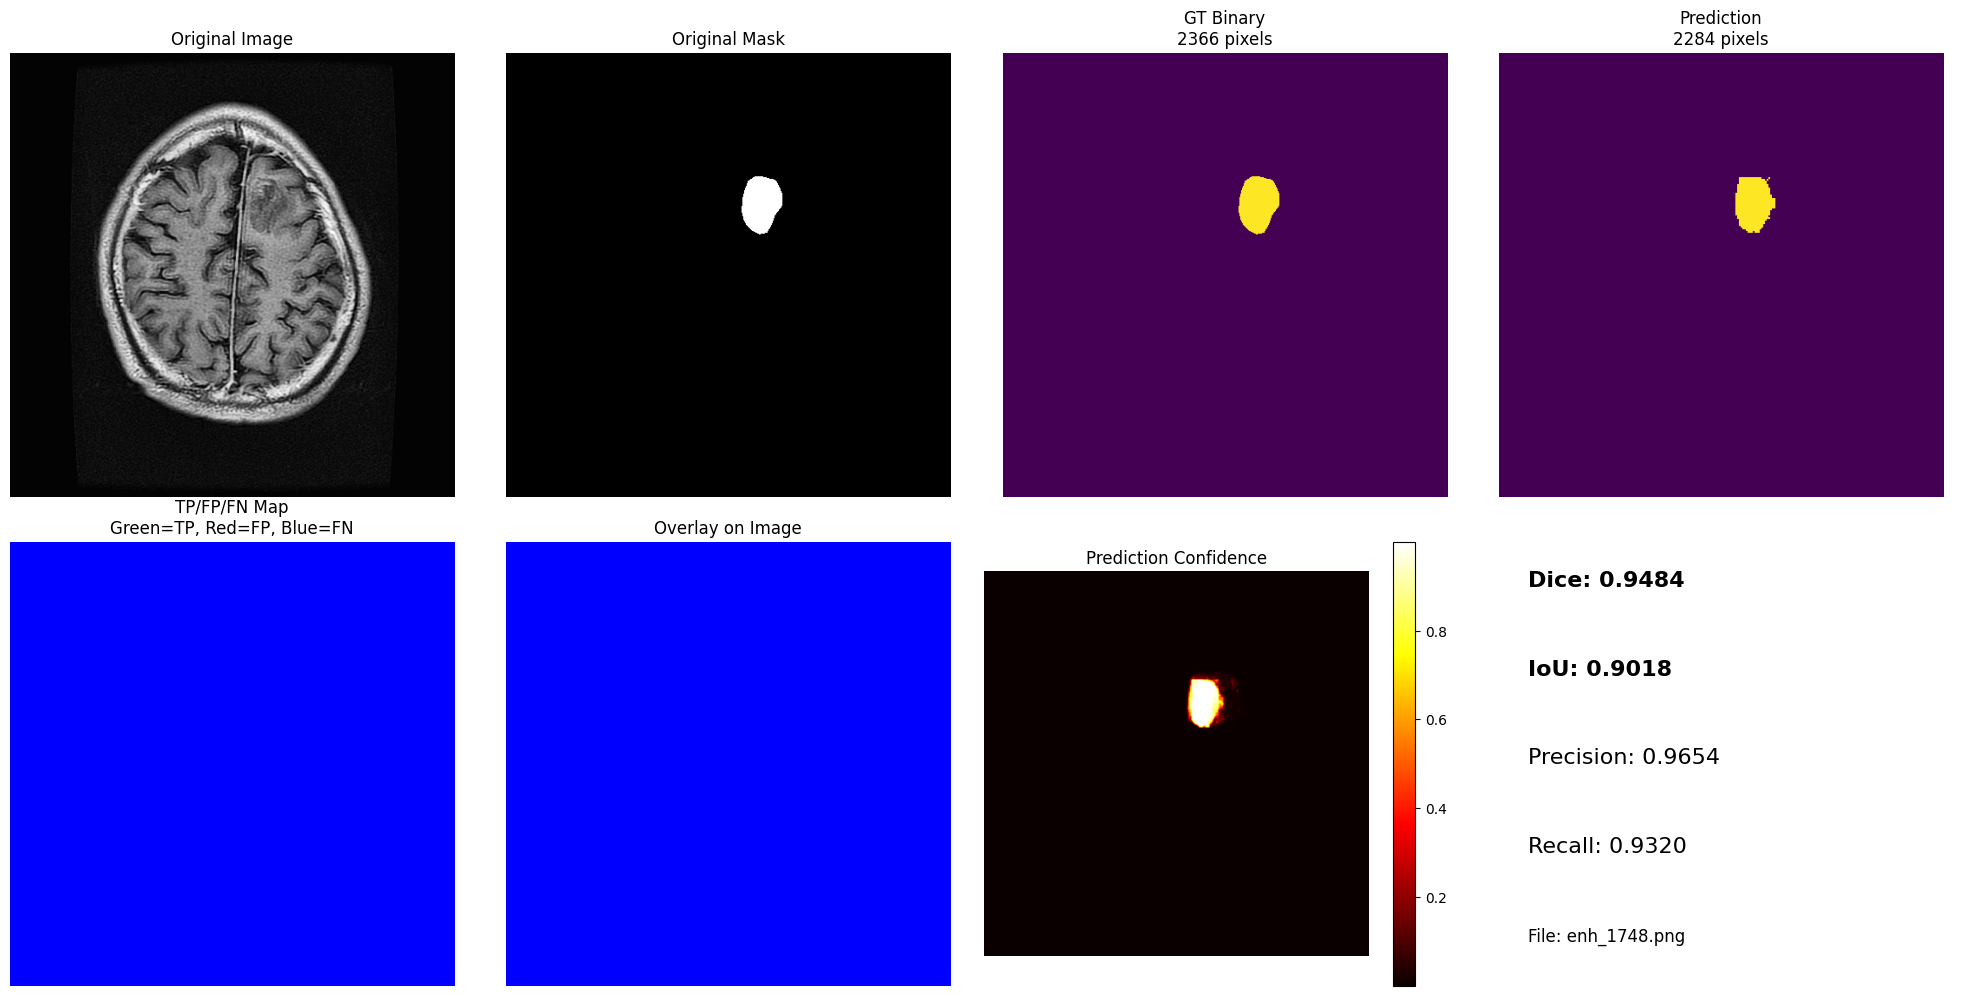


📋 SAMPLE 3: enh_1027.png
   Original mask values: [  3 255]
   GT binary pixels: 766
   Predicted pixels: 820
   True Positives:  649
   False Positives: 171
   False Negatives: 117
   Dice: 0.8184, IoU: 0.6926
   Precision: 0.7915, Recall: 0.8473


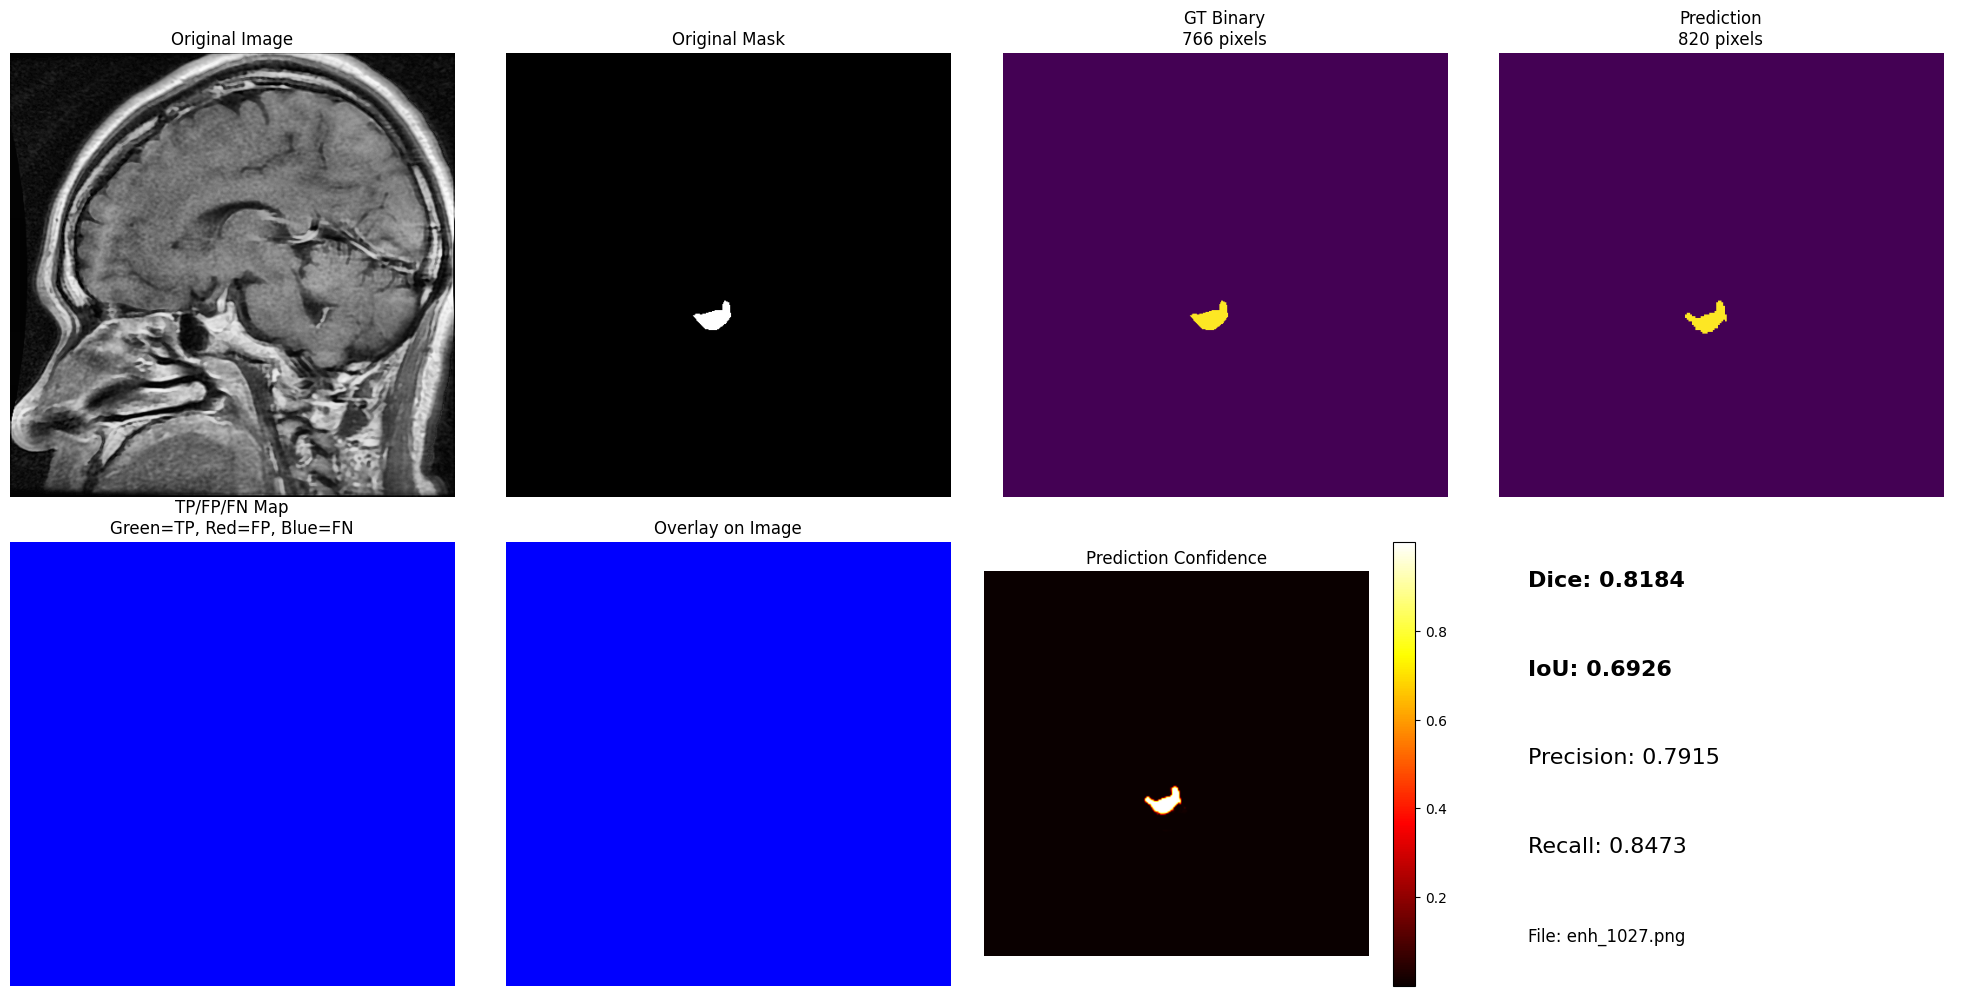


3. 🧠 TUMOR TYPE PERFORMANCE
🧠 TUMOR TYPE PERFORMANCE CHECK

🔍 First sample debug:
   Image: enh_962.png
   Mask: enh_962_mask.png
   Original mask values: [  3 255]
   Binary mask non-zero: 4303
   Image size: (512, 512), Mask size: (512, 512)
✅ Pituitary: Sample 1 - Dice: 0.9671
✅ Pituitary: Sample 2 - Dice: 0.8405
✅ Pituitary: Sample 3 - Dice: 0.9484

📊 TUMOR TYPE SUMMARY:
   Pituitary: 0.9187 ± 0.0558 (n=3)

🎉 THE MODEL IS PERFORMING Well!
   Average Dice: 0.9142



In [2]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import os

def comprehensive_visualization(model, dataset, num_samples=8):
    """COMPREHENSIVE visualization of images, ground truth, and predictions"""
    model.eval()

    print(f"🎯 VISUALIZING PREDICTIONS (Dice: 0.87)")
    print("=" * 60)

    # Create larger grid
    fig, axes = plt.subplots(num_samples, 5, figsize=(25, 5*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    all_dice_scores = []

    for i in range(num_samples):
        try:
            # Get sample
            sample = dataset[i]
            image_path = dataset.images[i]
            mask_path = dataset.masks[i]

            # Load original files
            original_image = np.array(Image.open(image_path).convert("RGB"))
            original_mask = np.array(Image.open(mask_path))

            # CORRECT binarization
            gt_binary = (original_mask == 255).astype(np.uint8)

            # Get prediction
            pixel_values = sample["pixel_values"].unsqueeze(0).cuda()
            input_boxes = sample["input_boxes"].unsqueeze(0).cuda()

            with torch.no_grad():
                outputs = model(
                    pixel_values=pixel_values,
                    input_boxes=input_boxes,
                    multimask_output=False,
                )

                pred_mask = torch.sigmoid(outputs.pred_masks.squeeze(2)).squeeze().cpu().numpy()

            # Resize prediction
            pred_binary = (pred_mask > 0.5).astype(np.uint8)
            pred_binary_resized = np.array(Image.fromarray(pred_binary).resize((512, 512), Image.NEAREST))

            # Calculate metrics
            intersection = np.logical_and(pred_binary_resized, gt_binary).sum()
            union = np.logical_or(pred_binary_resized, gt_binary).sum()
            dice = (2. * intersection) / (pred_binary_resized.sum() + gt_binary.sum())
            iou = intersection / union if union > 0 else 0

            all_dice_scores.append(dice)

            # ========== PLOTTING ==========

            # 1. Original Image
            axes[i, 0].imshow(original_image)
            axes[i, 0].set_title(f"Input Image\n{os.path.basename(image_path)}", fontsize=14, weight='bold')
            axes[i, 0].axis('off')

            # 2. Original Mask (raw)
            axes[i, 1].imshow(original_mask, cmap='gray')
            axes[i, 1].set_title(f"Original Mask\nValues: {np.unique(original_mask)}", fontsize=14)
            axes[i, 1].axis('off')

            # 3. Ground Truth Binary
            axes[i, 2].imshow(gt_binary, cmap='viridis')
            axes[i, 2].set_title(f"Ground Truth Binary\nPixels: {gt_binary.sum()}", fontsize=14, weight='bold')
            axes[i, 2].axis('off')

            # 4. Prediction
            axes[i, 3].imshow(pred_binary_resized, cmap='viridis')
            axes[i, 3].set_title(f"Prediction\nPixels: {pred_binary_resized.sum()}", fontsize=14, weight='bold')
            axes[i, 3].axis('off')

            # 5. Overlay Comparison
            overlay = original_image.copy()
            # Green for correct predictions (True Positives)
            overlay[np.logical_and(pred_binary_resized == 1, gt_binary == 1)] = [0, 255, 0]
            # Red for false positives
            overlay[np.logical_and(pred_binary_resized == 1, gt_binary == 0)] = [255, 0, 0]
            # Blue for false negatives
            overlay[np.logical_and(pred_binary_resized == 0, gt_binary == 1)] = [0, 0, 255]

            axes[i, 4].imshow(overlay)
            axes[i, 4].set_title(f"Overlay\nDice: {dice:.3f}, IoU: {iou:.3f}", fontsize=14, weight='bold')
            axes[i, 4].axis('off')

            print(f"✅ Sample {i}: Dice = {dice:.4f}, IoU = {iou:.4f}")
            print(f"   GT: {gt_binary.sum()} pixels, Pred: {pred_binary_resized.sum()} pixels")
            print(f"   File: {os.path.basename(image_path)}")

        except Exception as e:
            print(f"❌ Error in sample {i}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n📊 SUMMARY: Average Dice = {np.mean(all_dice_scores):.4f} ± {np.std(all_dice_scores):.4f}")
    return all_dice_scores

def detailed_sample_analysis(model, dataset, sample_indices=[0, 1, 2]):
    """DETAILED analysis of specific samples"""
    print("🔬 DETAILED SAMPLE ANALYSIS")
    print("=" * 50)

    for idx in sample_indices:
        try:
            sample = dataset[idx]
            image_path = dataset.images[idx]
            mask_path = dataset.masks[idx]

            # Load data
            original_image = np.array(Image.open(image_path).convert("RGB"))
            original_mask = np.array(Image.open(mask_path))
            gt_binary = (original_mask == 255).astype(np.uint8)

            # Get prediction
            pixel_values = sample["pixel_values"].unsqueeze(0).cuda()
            input_boxes = sample["input_boxes"].unsqueeze(0).cuda()

            with torch.no_grad():
                outputs = model(
                    pixel_values=pixel_values,
                    input_boxes=input_boxes,
                    multimask_output=False,
                )

                pred_mask = torch.sigmoid(outputs.pred_masks.squeeze(2)).squeeze().cpu().numpy()

            pred_binary = (pred_mask > 0.5).astype(np.uint8)
            pred_binary_resized = np.array(Image.fromarray(pred_binary).resize((512, 512), Image.NEAREST))

            # Calculate detailed metrics
            intersection = np.logical_and(pred_binary_resized, gt_binary).sum()
            union = np.logical_or(pred_binary_resized, gt_binary).sum()
            fp = np.logical_and(pred_binary_resized == 1, gt_binary == 0).sum()
            fn = np.logical_and(pred_binary_resized == 0, gt_binary == 1).sum()
            tp = intersection
            tn = np.logical_and(pred_binary_resized == 0, gt_binary == 0).sum()

            dice = (2. * tp) / (pred_binary_resized.sum() + gt_binary.sum())
            iou = tp / union if union > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            print(f"\n📋 SAMPLE {idx}: {os.path.basename(image_path)}")
            print(f"   Original mask values: {np.unique(original_mask)}")
            print(f"   GT binary pixels: {gt_binary.sum()}")
            print(f"   Predicted pixels: {pred_binary_resized.sum()}")
            print(f"   True Positives:  {tp}")
            print(f"   False Positives: {fp}")
            print(f"   False Negatives: {fn}")
            print(f"   Dice: {dice:.4f}, IoU: {iou:.4f}")
            print(f"   Precision: {precision:.4f}, Recall: {recall:.4f}")

            # Create detailed visualization for this sample
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))

            # Row 1
            axes[0,0].imshow(original_image)
            axes[0,0].set_title("Original Image")
            axes[0,0].axis('off')

            axes[0,1].imshow(original_mask, cmap='gray')
            axes[0,1].set_title("Original Mask")
            axes[0,1].axis('off')

            axes[0,2].imshow(gt_binary, cmap='viridis')
            axes[0,2].set_title(f"GT Binary\n{gt_binary.sum()} pixels")
            axes[0,2].axis('off')

            axes[0,3].imshow(pred_binary_resized, cmap='viridis')
            axes[0,3].set_title(f"Prediction\n{pred_binary_resized.sum()} pixels")
            axes[0,3].axis('off')

            # Row 2 - Detailed overlays
            # TP/FP/FN overlay
            overlay_detailed = np.zeros_like(original_image)
            overlay_detailed[tp > 0] = [0, 255, 0]    # Green = TP
            overlay_detailed[fp > 0] = [255, 0, 0]    # Red = FP
            overlay_detailed[fn > 0] = [0, 0, 255]    # Blue = FN

            axes[1,0].imshow(overlay_detailed)
            axes[1,0].set_title("TP/FP/FN Map\nGreen=TP, Red=FP, Blue=FN")
            axes[1,0].axis('off')

            # Overlay on original
            overlay_original = original_image.copy()
            overlay_original[tp > 0] = [0, 255, 0]    # Green = TP
            overlay_original[fp > 0] = [255, 0, 0]    # Red = FP
            overlay_original[fn > 0] = [0, 0, 255]    # Blue = FN

            axes[1,1].imshow(overlay_original)
            axes[1,1].set_title("Overlay on Image")
            axes[1,1].axis('off')

            # Prediction confidence
            pred_resized = np.array(Image.fromarray(pred_mask).resize((512, 512), Image.BILINEAR))
            im = axes[1,2].imshow(pred_resized, cmap='hot')
            axes[1,2].set_title("Prediction Confidence")
            axes[1,2].axis('off')
            plt.colorbar(im, ax=axes[1,2])

            # Metrics text
            axes[1,3].text(0.1, 0.9, f"Dice: {dice:.4f}", fontsize=16, weight='bold')
            axes[1,3].text(0.1, 0.7, f"IoU: {iou:.4f}", fontsize=16, weight='bold')
            axes[1,3].text(0.1, 0.5, f"Precision: {precision:.4f}", fontsize=16)
            axes[1,3].text(0.1, 0.3, f"Recall: {recall:.4f}", fontsize=16)
            axes[1,3].text(0.1, 0.1, f"File: {os.path.basename(image_path)}", fontsize=12)
            axes[1,3].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error in detailed analysis {idx}: {e}")
            continue

def check_different_tumor_types(model, dataset, num_samples_per_type=3):
    """Check performance across different tumor types"""
    print("🧠 TUMOR TYPE PERFORMANCE CHECK")
    print("=" * 50)

    tumor_types = {}

    for i in range(min(20, len(dataset))):
        try:
            image_path = dataset.images[i]

            # Determine tumor type from filename
            if "Pituitary" in image_path:
                tumor_type = "Pituitary"
            elif "Meningioma" in image_path:
                tumor_type = "Meningioma"
            elif "Glioma" in image_path:
                tumor_type = "Glioma"
            else:
                continue

            if tumor_type not in tumor_types:
                tumor_types[tumor_type] = []

            if len(tumor_types[tumor_type]) >= num_samples_per_type:
                continue

            # Calculate Dice for this sample
            sample = dataset[i]
            mask_path = dataset.masks[i]

            original_mask = np.array(Image.open(mask_path))
            gt_binary = (original_mask == 255).astype(np.uint8)

            pixel_values = sample["pixel_values"].unsqueeze(0).cuda()
            input_boxes = sample["input_boxes"].unsqueeze(0).cuda()

            with torch.no_grad():
                outputs = model(
                    pixel_values=pixel_values,
                    input_boxes=input_boxes,
                    multimask_output=False,
                )

                pred_mask = torch.sigmoid(outputs.pred_masks.squeeze(2)).squeeze().cpu().numpy()

            pred_binary = (pred_mask > 0.5).astype(np.uint8)
            pred_binary_resized = np.array(Image.fromarray(pred_binary).resize((512, 512), Image.NEAREST))

            dice = dice_score_np(pred_binary_resized, gt_binary)
            tumor_types[tumor_type].append(dice)

            print(f"✅ {tumor_type}: Sample {len(tumor_types[tumor_type])} - Dice: {dice:.4f}")

        except Exception as e:
            continue

    # Print summary
    print(f"\n📊 TUMOR TYPE SUMMARY:")
    for tumor_type, scores in tumor_types.items():
        if scores:
            print(f"   {tumor_type}: {np.mean(scores):.4f} ± {np.std(scores):.4f} (n={len(scores)})")

def dice_score_np(pred, target):
    """Dice score calculation"""
    intersection = np.logical_and(pred, target).sum()
    return (2. * intersection) / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) > 0 else 0

# 🚀 RUN THE COMPREHENSIVE ANALYSIS
print("🎯 RUNNING COMPREHENSIVE ANALYSIS FOR 0.87 DICE MODEL")
print("=" * 70)

# 1. Main visualization
print("\n1. 📊 COMPREHENSIVE VISUALIZATION")
dice_scores = comprehensive_visualization(trained_model, final_dataset, num_samples=6)

# 2. Detailed analysis of first few samples
print("\n2. 🔬 DETAILED SAMPLE ANALYSIS")
detailed_sample_analysis(trained_model, final_dataset, sample_indices=[0, 1, 2, 3])

# 3. Check different tumor types
print("\n3. 🧠 TUMOR TYPE PERFORMANCE")
check_different_tumor_types(trained_model, final_dataset)

print(f"\n🎉 THE MODEL IS PERFORMING Well!")
print(f"   Average Dice: {np.mean(dice_scores):.4f}")
print(f"")